In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt #plotolásra
import matlab.engine #MATLABhoz
import time #teljesítmény mérésre

In [79]:
max_steps_per_episode = 100

In [80]:
eng=matlab.engine.start_matlab()

In [91]:
model='NoControl';
eng.load_system(model)

0.0001220703125

In [92]:
eng.workspace['model']=model

In [93]:
eng.find_system(model,'Type','Block')

['NoControl/Actuator',
 'NoControl/Assertion',
 'NoControl/Clock',
 'NoControl/Constant1',
 'NoControl/Display',
 'NoControl/Plant',
 'NoControl/Relational\nOperator',
 'NoControl/Scope',
 'NoControl/Step',
 'NoControl/Sum',
 'NoControl/OUTPUT',
 'NoControl/Time',
 'NoControl/Error']

In [94]:
eng.get_param([model+'/Plant'],'Numerator')# példa blokk paraméter beolvasásra

['plant.Numerator{1,1}']

In [95]:
eng.workspace['plant']=eng.eval("tf(5,conv(conv([10 1],[4 1]),[1 1]))") #veszélyes, mivel elsőnek átalakítja valami python változóba
eng.workspace['control']=eng.eval("tf([3.51 1.229 0.08776],[0.351 1 0])")#s csak aztán adja át a matlabos változónak

In [96]:
eng.workspace['actuator']=1.0

In [97]:
state=eng.get_param(model,'SimulationStatus')
hiba=0
state

'stopped'

In [98]:
eng.workspace['actuator']=1.0 #kezdeti init és paraméter átadás a workspacenek
#Simulink modell elindítása
eng.set_param(model, 'SimulationCommand', 'start', nargout=0);
x=[]
y=[]
timesteps=0
while (eng.get_param(model,'SimulationStatus')!=('stopped' or 'terminating')) and (max_steps_per_episode>timesteps) :
    if eng.get_param(model,'SimulationStatus')=='paused':
        #paraméterek írása és olvasása
        kimenet=eng.eval("get_param([model '/OUTPUT'],'RuntimeObject').InputPort(1).Data")
        ido=eng.eval("get_param([model '/Time'],'RuntimeObject').InputPort(1).Data")
        hiba=eng.eval("get_param([model '/Error'],'RuntimeObject').InputPort(1).Data")
        eng.workspace['actuator']=hiba
        x.append(ido)
        y.append(kimenet)
        eng.set_param(model,'SimulationCommand','update',nargout=0) #szimulációs paraméterek beírása
        eng.set_param(model,'SimulationCommand','continue',nargout=0)#szimuláció folytatása
    timesteps=timesteps+1
eng.set_param(model,'SimulationCommand','stop',nargout=0) #szimuláció megállítása egy episode után

In [99]:
#plt.plot(x,y,x,hibak,'r--')
timesteps

100

In [100]:
plt.plot(x,y)

In [122]:
# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 100
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [123]:
# neurális hálók
num_inputs = 6
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model1 = keras.Model(inputs=inputs, outputs=[action, critic])# model név már foglalt...

In [124]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

In [125]:
def simulation_step(action, timestep):#egy megállított állapotból átvisz a következő megállított állapotra
    eng.workspace['actuator']=action
    eng.set_param(model,'SimulationCommand','update',nargout=0) #szimulációs paraméterek beírása
    if timestep==0:
        eng.set_param(model, 'SimulationCommand', 'start', nargout=0)#Simulink modell elindítása
    else:    
        eng.set_param(model,'SimulationCommand','continue',nargout=0)#szimuláció folytatása   
    status=eng.get_param(model,'SimulationStatus')    
    while (status!='paused') and ((status!=("stopped")) and (status!=("terminating"))):#megvárjuk míg lefut a szimulációs lépés
        eng.pause(0.05) #nem igazán lassít, mivel szinte soha se lép be ide
        status=eng.get_param(model,'SimulationStatus')
        print("Pausoltunk!")#szerencsére ezt se látni sose, csak debug céllal
    #lefutott
    #paraméterek kiolvasása
    if ((status!=("stopped")) and (status!=("terminating"))):
        kimenet=eng.eval("get_param([model '/OUTPUT'],'RuntimeObject').InputPort(1).Data")
        ido=eng.eval("get_param([model '/Time'],'RuntimeObject').InputPort(1).Data")
        hiba=eng.eval("get_param([model '/Error'],'RuntimeObject').InputPort(1).Data")

    return hiba, kimenet, ido

19.19001056604113

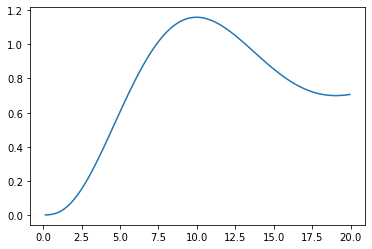

In [126]:
huba=1.0
xs=[]
ys=[]
sum_huba=0
timesteps=0
for i in range(100):
    huba,y,x=simulation_step(huba,timesteps)
    timesteps=timesteps+1
    #print(timesteps)
    #print(x)
    #print(y)
    xs.append(x)
    ys.append(y)
    sum_huba=huba**2+sum_huba
eng.set_param(model, 'SimulationCommand', 'stop', nargout=0)#Simulink modell elindítása
plt.plot(xs,ys)
sum_huba
#SIKER

In [127]:
def step_value(hiba,prev_state):
    state = tf.convert_to_tensor(prev_state)
    state = tf.expand_dims(state, 0)                
    state=np.append(state,hiba)
    state=np.delete(state,0)
    reward=-hiba**2 #reward kiszámítása
    done= False #fusson le mindig nyugodtan most még
    return state, reward, done

running reward: -21.27 at episode 10


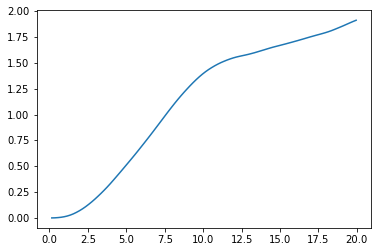

running reward: -35.40 at episode 20


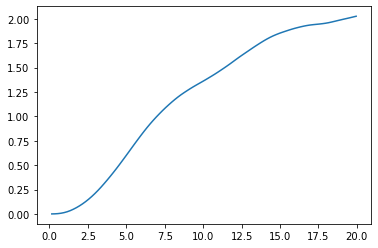

running reward: -42.20 at episode 30


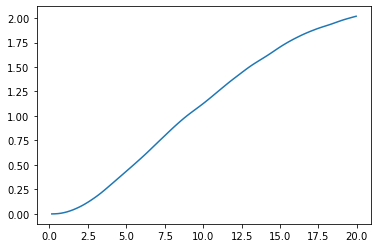

running reward: -44.72 at episode 40


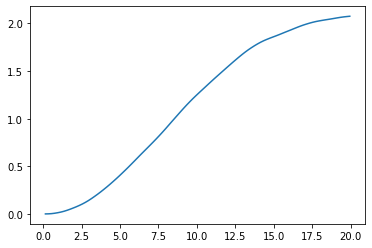

running reward: -48.95 at episode 50


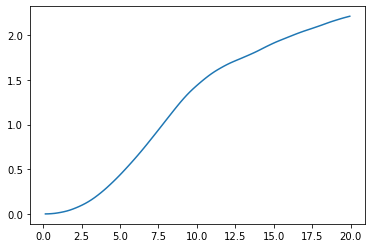

running reward: -48.06 at episode 60


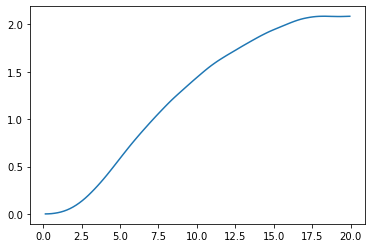

running reward: -46.82 at episode 70


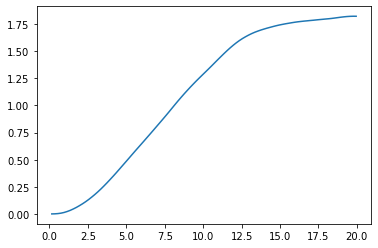

running reward: -44.39 at episode 80


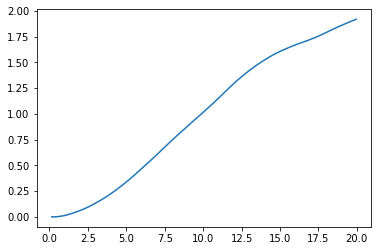

running reward: -42.27 at episode 90


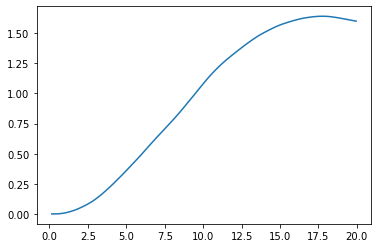

running reward: -41.79 at episode 100


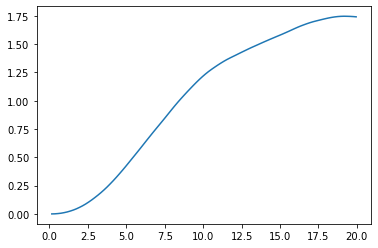

running reward: -41.06 at episode 110


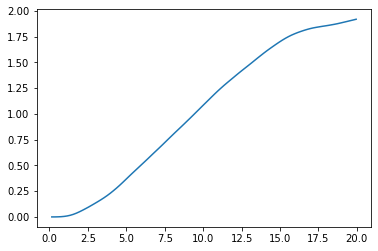

running reward: -40.33 at episode 120


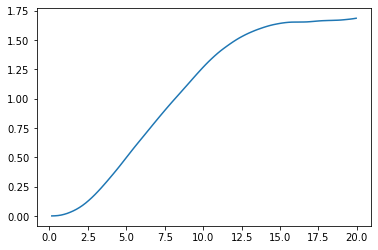

running reward: -40.89 at episode 130


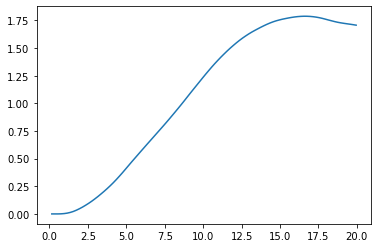

running reward: -41.05 at episode 140


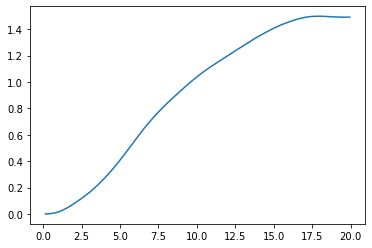

running reward: -41.48 at episode 150


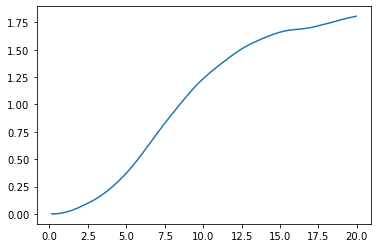

running reward: -41.05 at episode 160


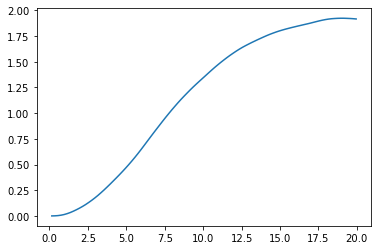

running reward: -43.65 at episode 170


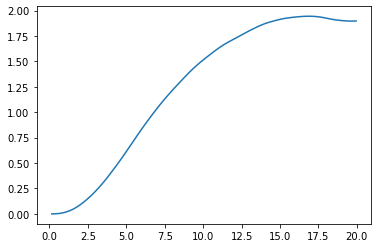

running reward: -46.58 at episode 180


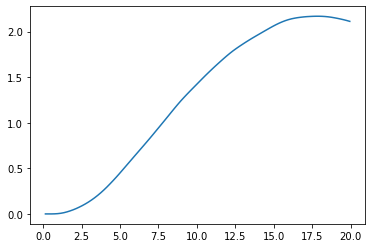

running reward: -47.12 at episode 190


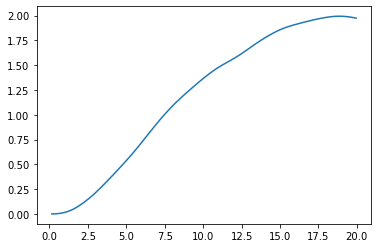

running reward: -45.26 at episode 200


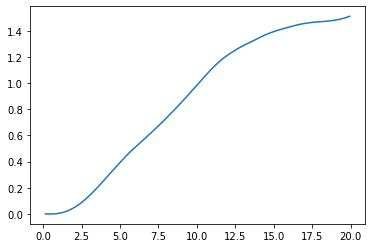

running reward: -45.26 at episode 210


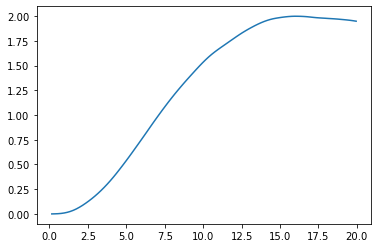

running reward: -44.36 at episode 220


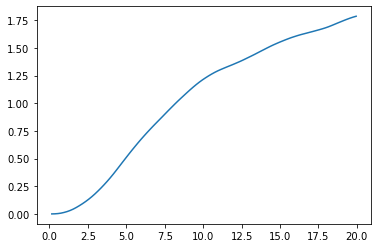

running reward: -44.49 at episode 230


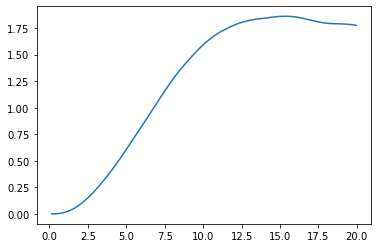

running reward: -44.14 at episode 240


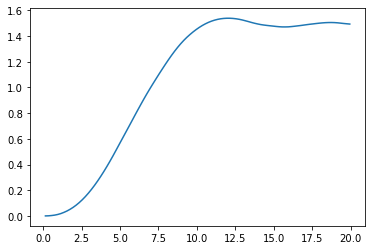

running reward: -44.81 at episode 250


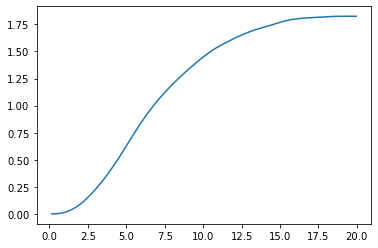

running reward: -42.48 at episode 260


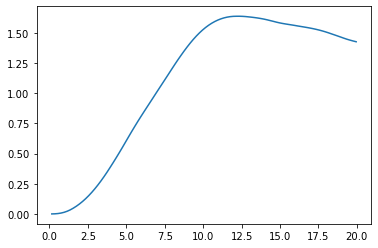

running reward: -43.41 at episode 270


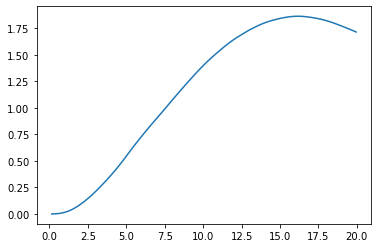

running reward: -41.90 at episode 280


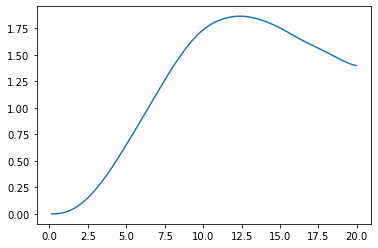

running reward: -40.18 at episode 290


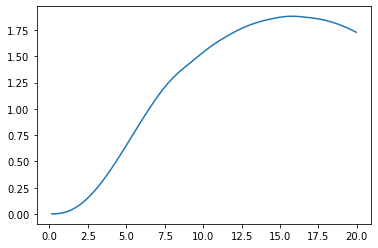

running reward: -40.26 at episode 300


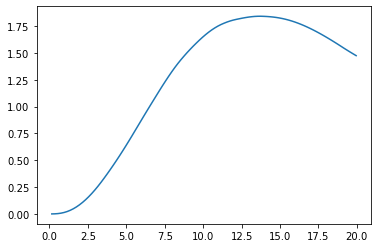

running reward: -39.29 at episode 310


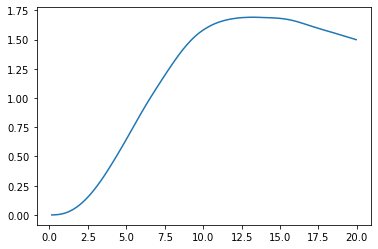

running reward: -39.78 at episode 320


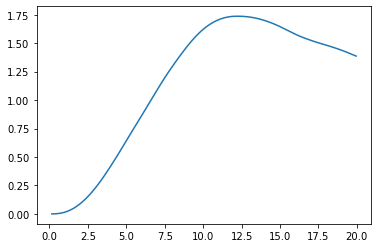

running reward: -38.63 at episode 330


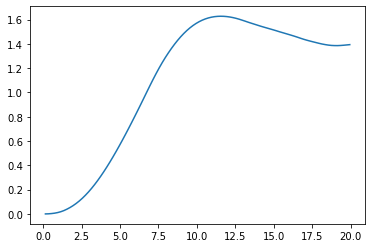

running reward: -39.37 at episode 340


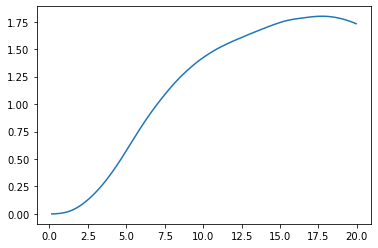

running reward: -39.12 at episode 350


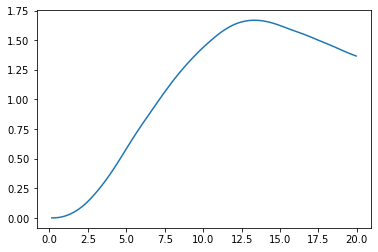

running reward: -38.74 at episode 360


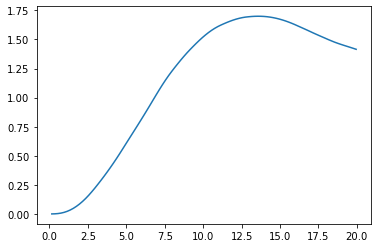

running reward: -36.98 at episode 370


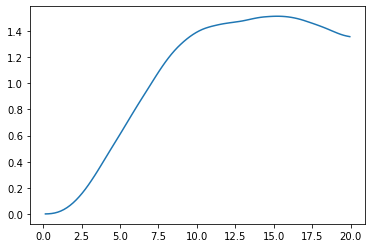

running reward: -35.28 at episode 380


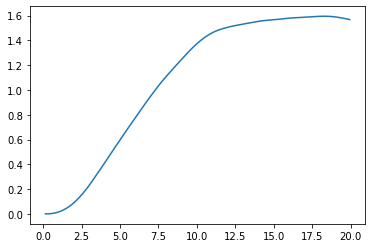

running reward: -33.82 at episode 390


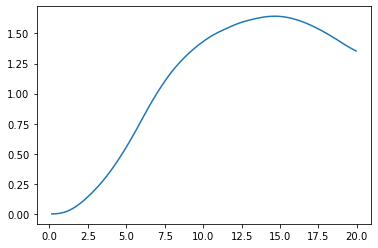

running reward: -33.69 at episode 400


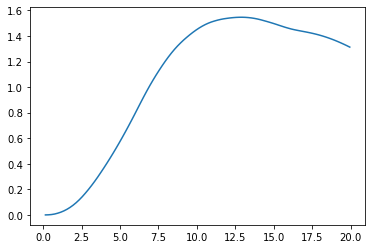

running reward: -34.61 at episode 410


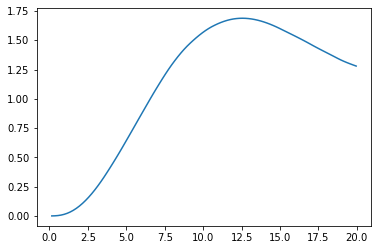

running reward: -35.04 at episode 420


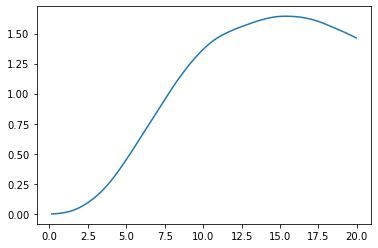

running reward: -33.13 at episode 430


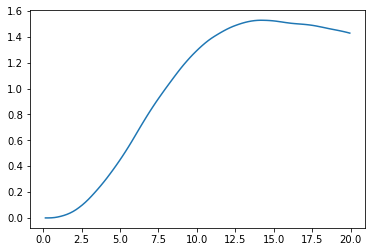

running reward: -32.89 at episode 440


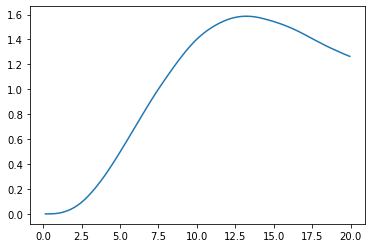

running reward: -32.94 at episode 450


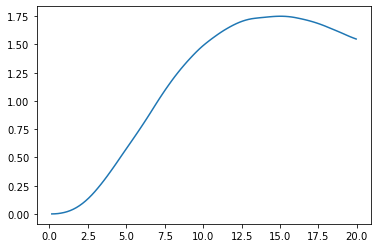

running reward: -33.40 at episode 460


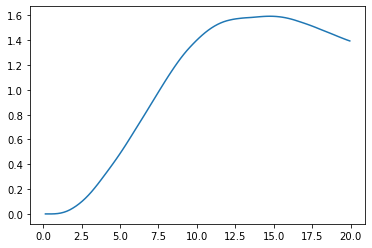

running reward: -32.94 at episode 470


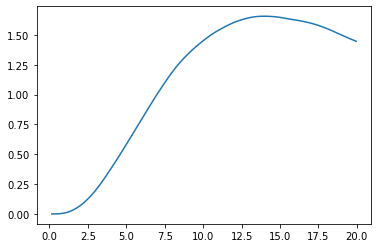

running reward: -32.98 at episode 480


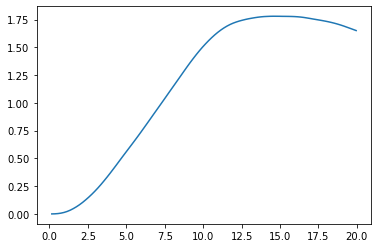

running reward: -33.15 at episode 490


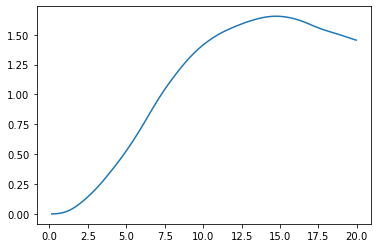

running reward: -32.85 at episode 500


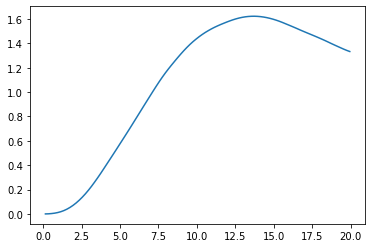

running reward: -32.47 at episode 510


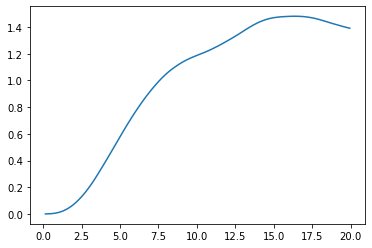

running reward: -31.66 at episode 520


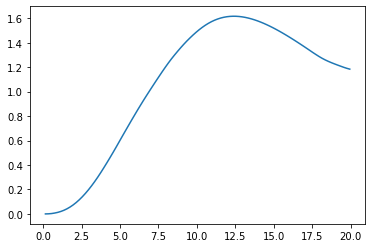

running reward: -31.93 at episode 530


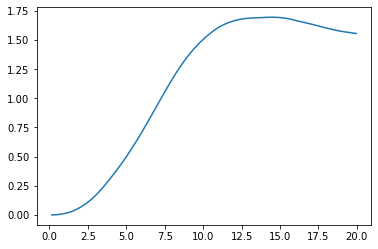

running reward: -30.64 at episode 540


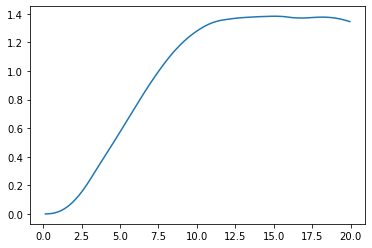

running reward: -30.73 at episode 550


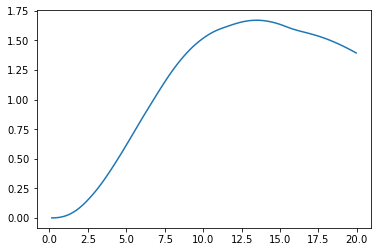

running reward: -30.95 at episode 560


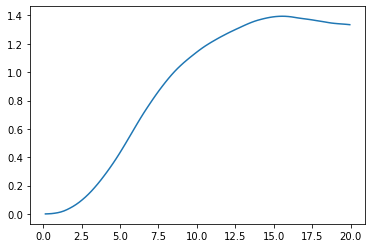

running reward: -31.09 at episode 570


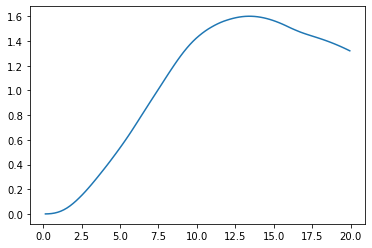

running reward: -31.02 at episode 580


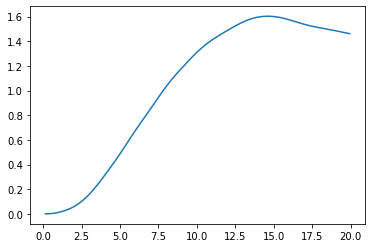

running reward: -30.21 at episode 590


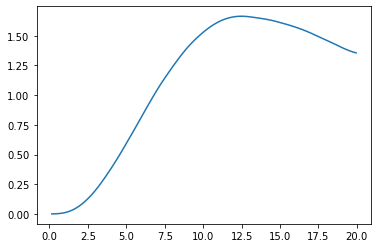

running reward: -31.72 at episode 600


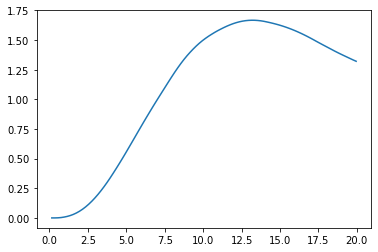

running reward: -31.25 at episode 610


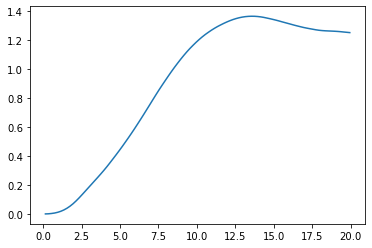

running reward: -30.57 at episode 620


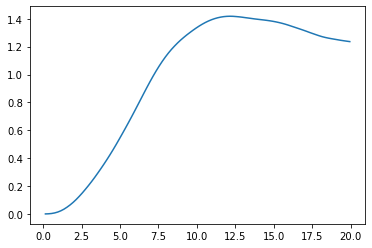

running reward: -31.08 at episode 630


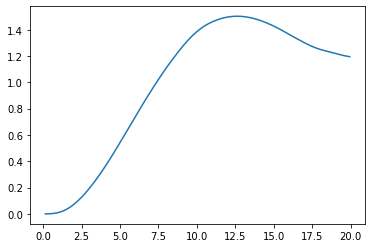

running reward: -32.16 at episode 640


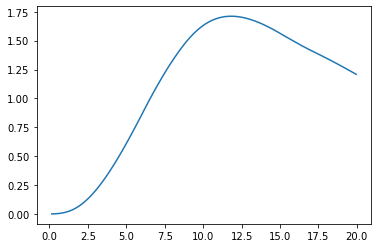

running reward: -31.13 at episode 650


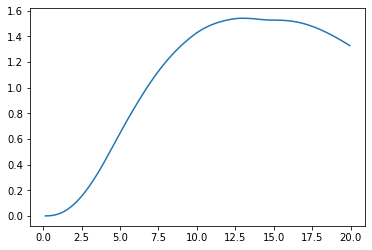

running reward: -32.17 at episode 660


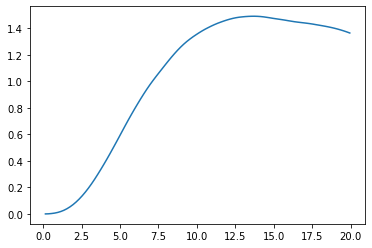

running reward: -31.52 at episode 670


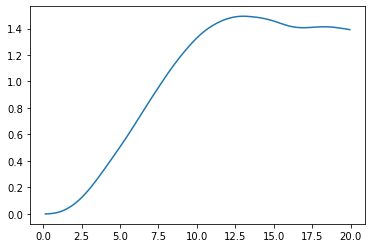

running reward: -30.53 at episode 680


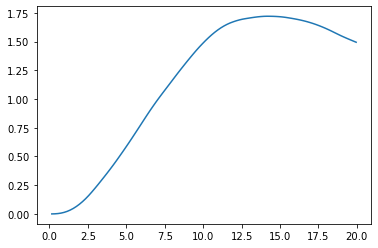

running reward: -30.10 at episode 690


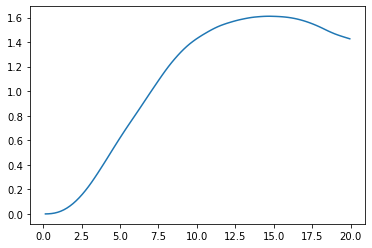

running reward: -29.77 at episode 700


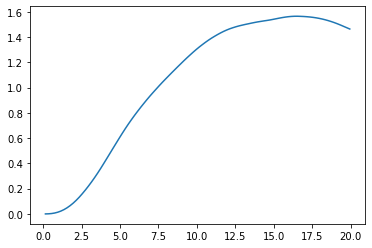

running reward: -30.28 at episode 710


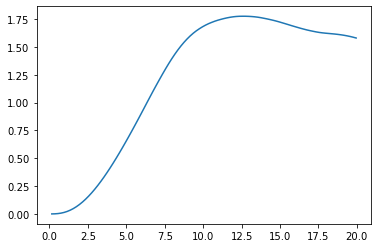

running reward: -31.78 at episode 720


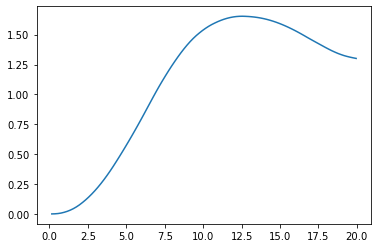

running reward: -31.20 at episode 730


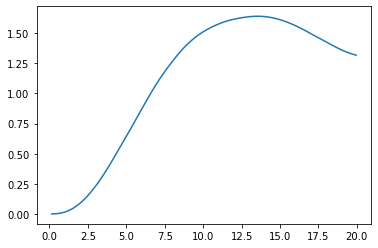

running reward: -31.38 at episode 740


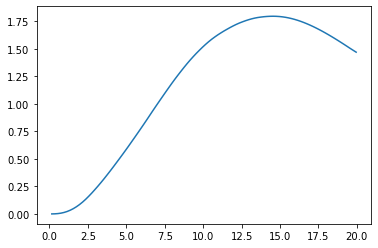

running reward: -32.46 at episode 750


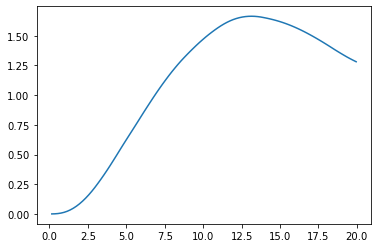

running reward: -32.20 at episode 760


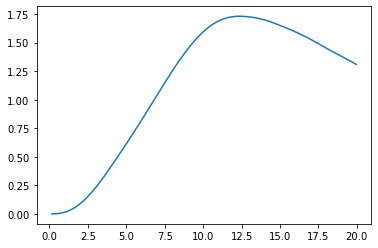

running reward: -31.64 at episode 770


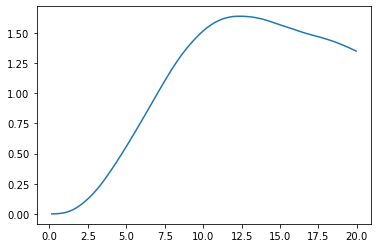

running reward: -31.87 at episode 780


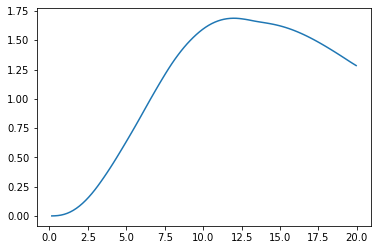

running reward: -31.22 at episode 790


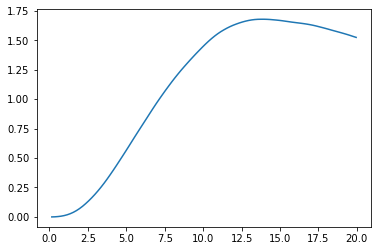

running reward: -30.31 at episode 800


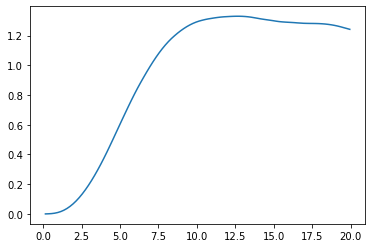

running reward: -30.45 at episode 810


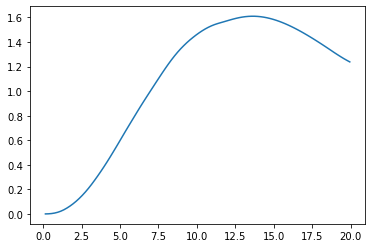

running reward: -29.98 at episode 820


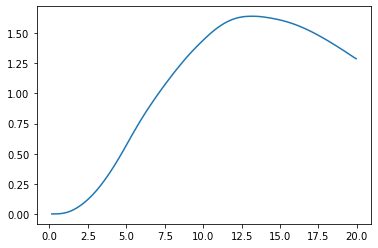

running reward: -29.82 at episode 830


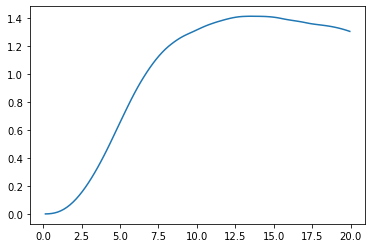

running reward: -29.27 at episode 840


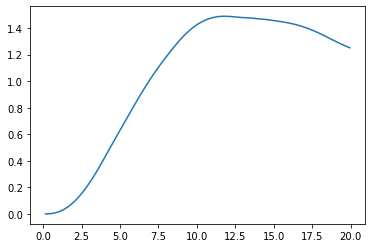

running reward: -28.58 at episode 850


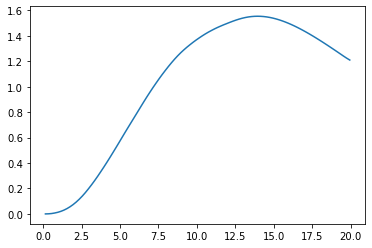

running reward: -28.79 at episode 860


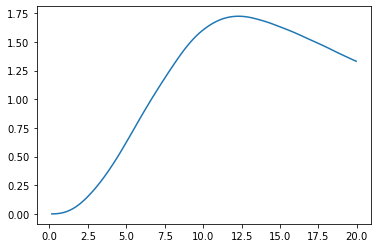

running reward: -28.05 at episode 870


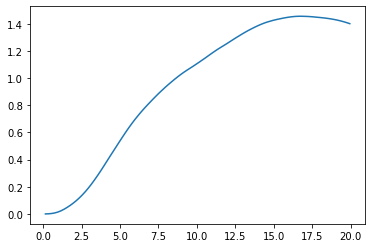

running reward: -27.92 at episode 880


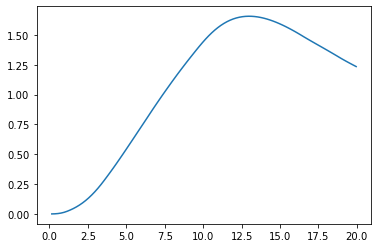

running reward: -27.42 at episode 890


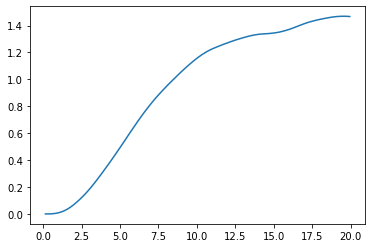

running reward: -27.13 at episode 900


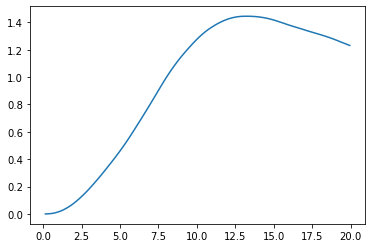

running reward: -26.26 at episode 910


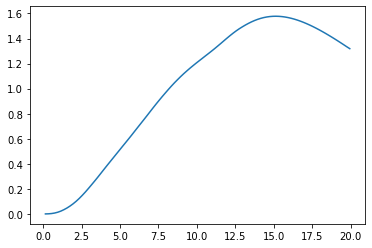

running reward: -25.99 at episode 920


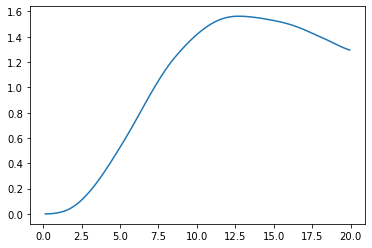

running reward: -24.68 at episode 930


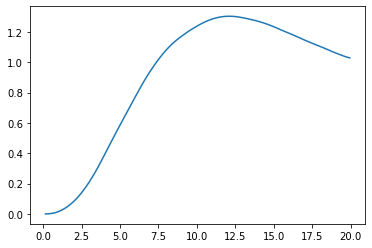

running reward: -24.08 at episode 940


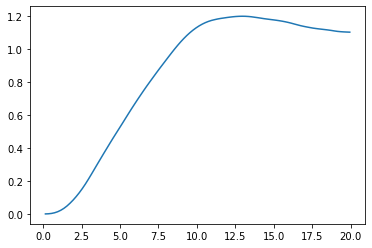

running reward: -23.85 at episode 950


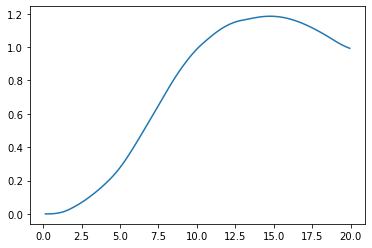

running reward: -23.80 at episode 960


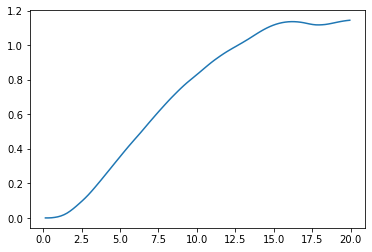

running reward: -24.63 at episode 970


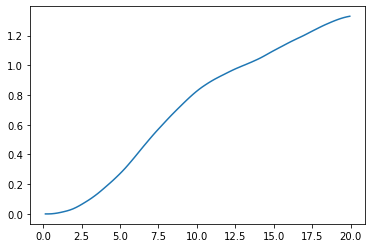

running reward: -26.40 at episode 980


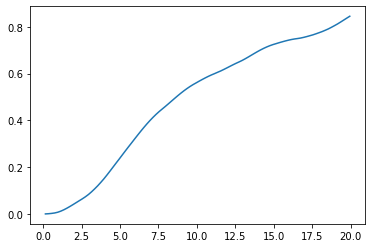

running reward: -27.00 at episode 990


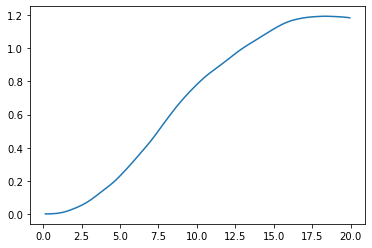

running reward: -29.35 at episode 1000


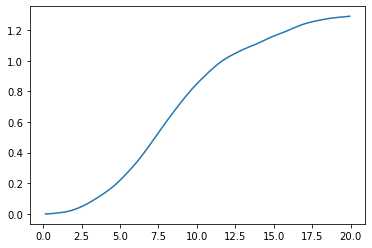

running reward: -28.57 at episode 1010


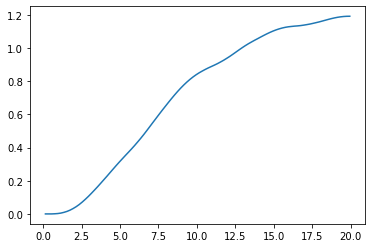

running reward: -29.08 at episode 1020


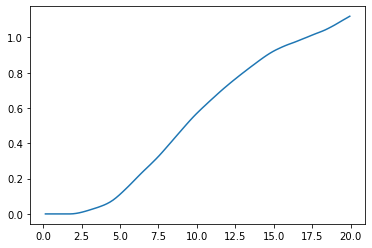

running reward: -27.95 at episode 1030


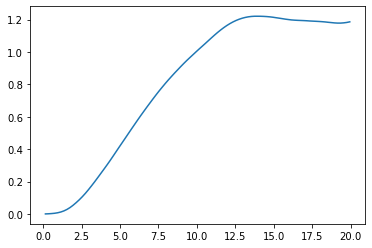

running reward: -26.98 at episode 1040


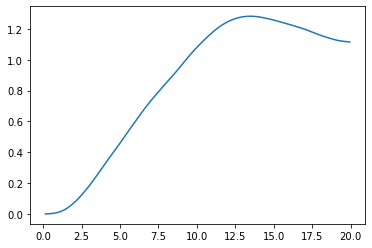

running reward: -26.22 at episode 1050


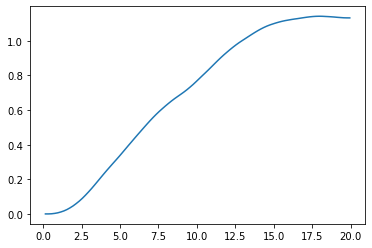

running reward: -28.01 at episode 1060


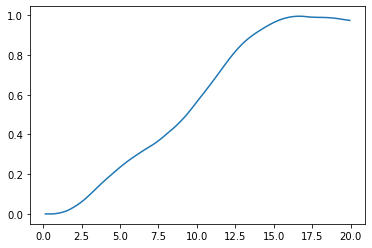

running reward: -31.61 at episode 1070


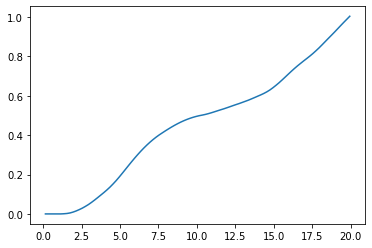

running reward: -32.73 at episode 1080


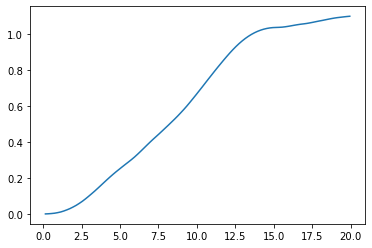

running reward: -37.08 at episode 1090


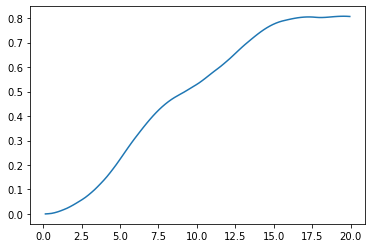

running reward: -41.89 at episode 1100


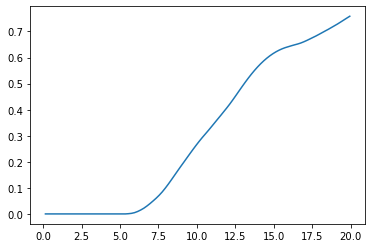

running reward: -43.48 at episode 1110


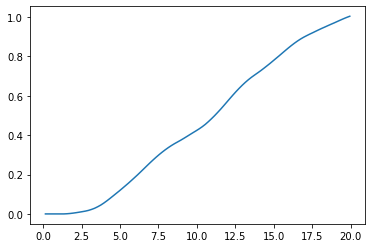

running reward: -41.59 at episode 1120


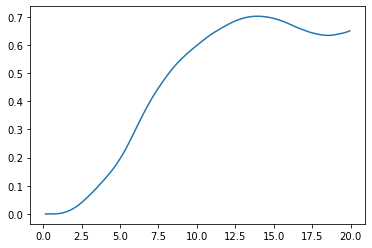

running reward: -39.33 at episode 1130


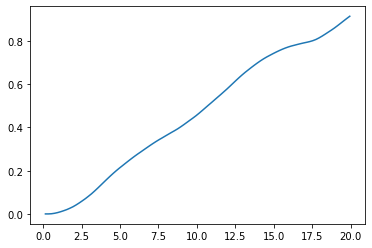

running reward: -36.43 at episode 1140


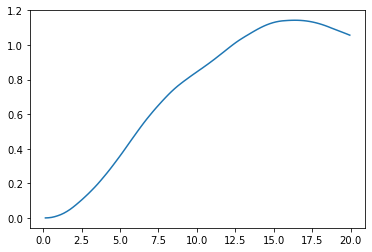

running reward: -33.06 at episode 1150


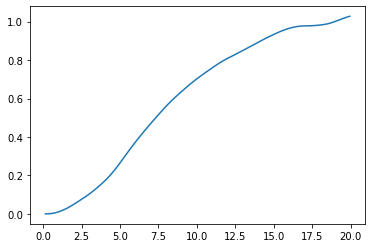

running reward: -31.88 at episode 1160


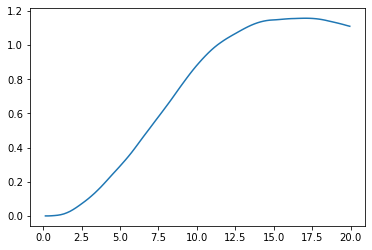

running reward: -31.59 at episode 1170


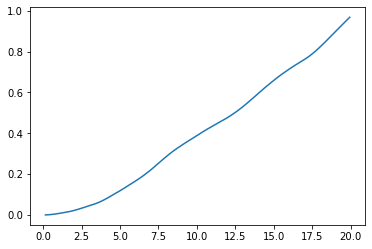

running reward: -31.98 at episode 1180


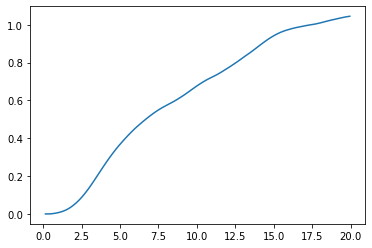

running reward: -31.06 at episode 1190


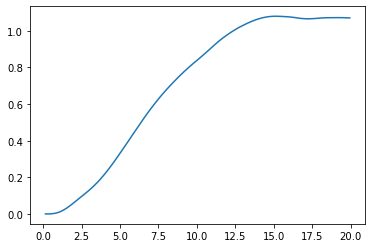

running reward: -31.65 at episode 1200


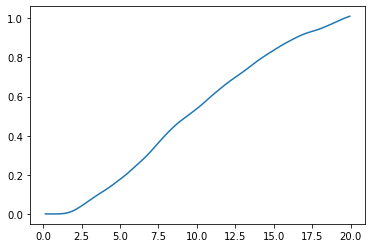

running reward: -31.80 at episode 1210


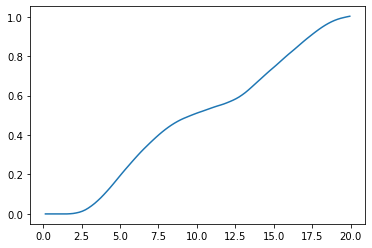

running reward: -32.54 at episode 1220


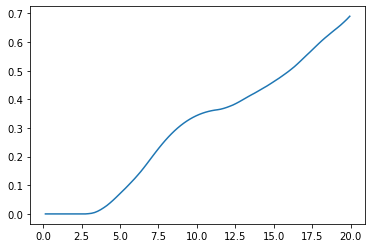

running reward: -30.88 at episode 1230


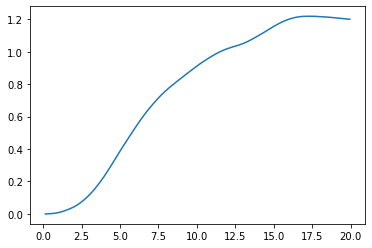

running reward: -30.53 at episode 1240


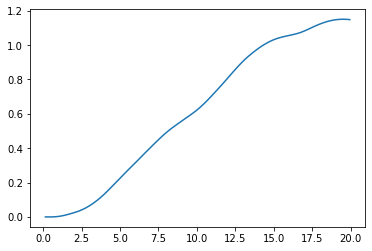

running reward: -30.36 at episode 1250


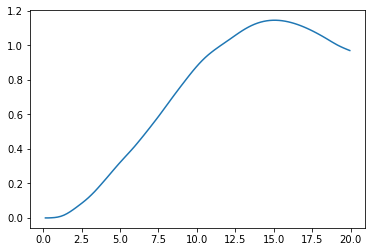

running reward: -28.70 at episode 1260


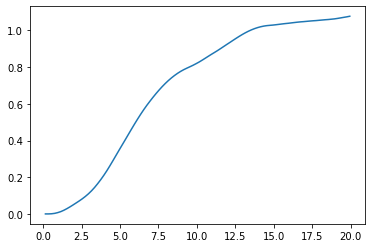

running reward: -27.43 at episode 1270


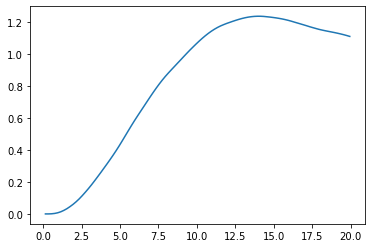

running reward: -25.93 at episode 1280


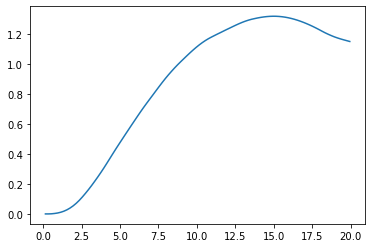

running reward: -25.23 at episode 1290


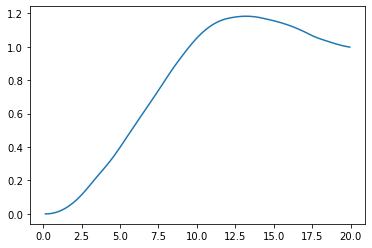

running reward: -25.37 at episode 1300


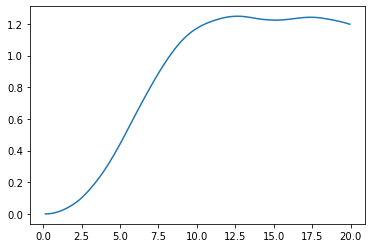

running reward: -24.95 at episode 1310


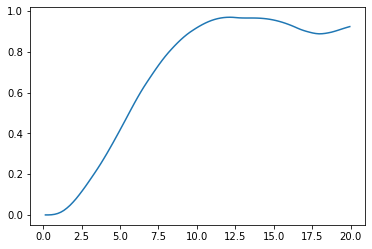

running reward: -26.04 at episode 1320


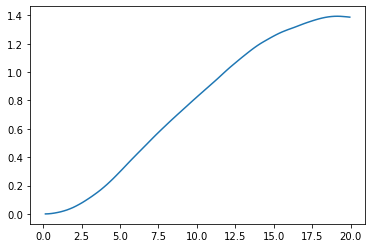

running reward: -26.74 at episode 1330


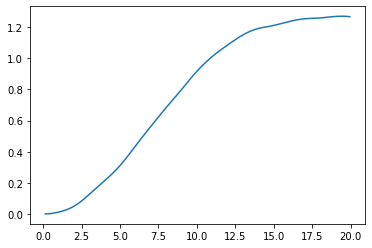

running reward: -26.24 at episode 1340


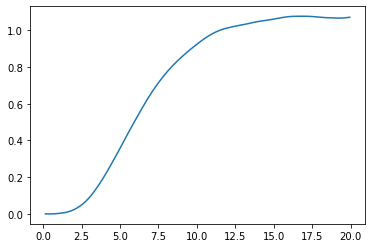

running reward: -25.95 at episode 1350


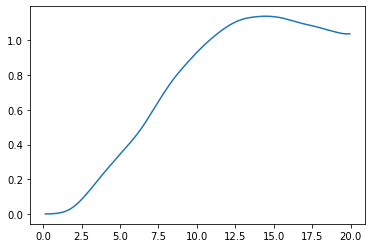

running reward: -26.31 at episode 1360


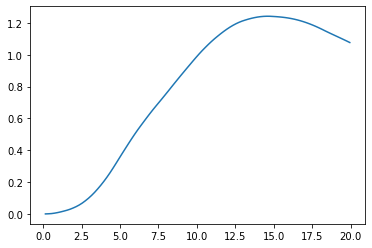

running reward: -26.35 at episode 1370


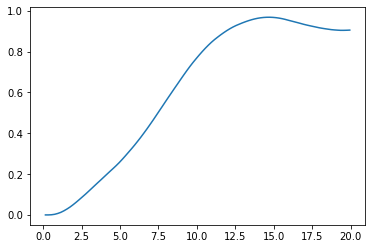

running reward: -25.69 at episode 1380


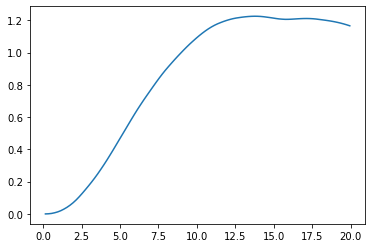

running reward: -25.48 at episode 1390


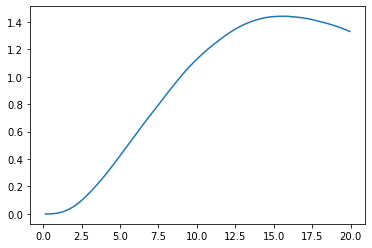

running reward: -25.41 at episode 1400


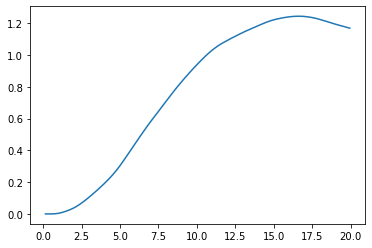

running reward: -24.59 at episode 1410


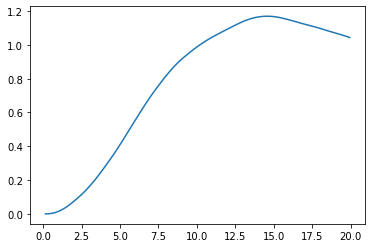

running reward: -25.15 at episode 1420


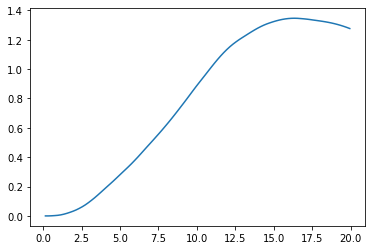

running reward: -25.34 at episode 1430


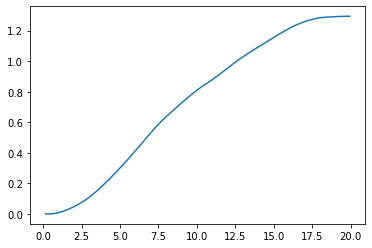

running reward: -26.23 at episode 1440


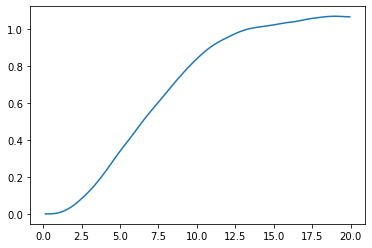

running reward: -26.76 at episode 1450


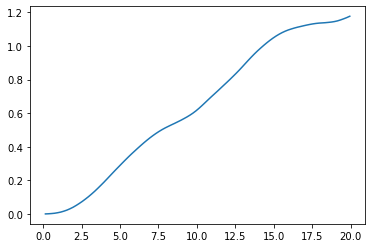

running reward: -27.17 at episode 1460


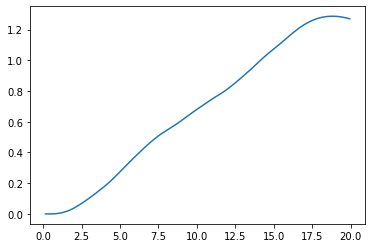

running reward: -27.18 at episode 1470


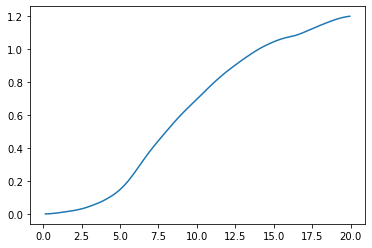

running reward: -27.77 at episode 1480


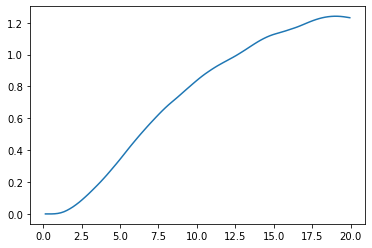

running reward: -27.45 at episode 1490


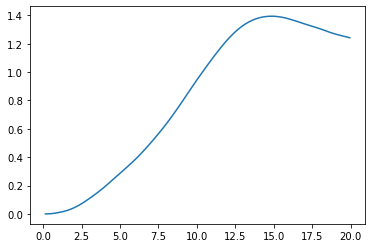

running reward: -27.47 at episode 1500


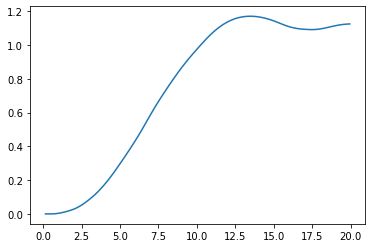

running reward: -27.58 at episode 1510


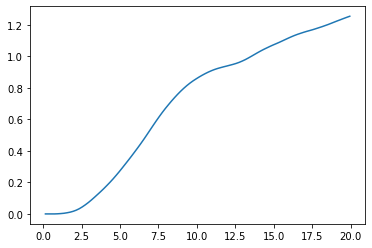

running reward: -26.96 at episode 1520


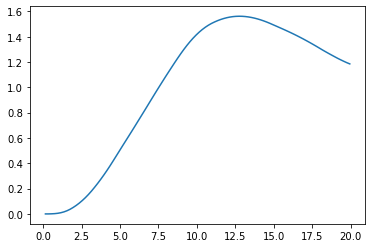

running reward: -26.00 at episode 1530


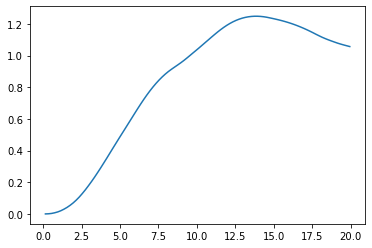

running reward: -26.34 at episode 1540


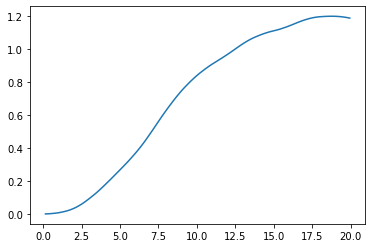

running reward: -26.81 at episode 1550


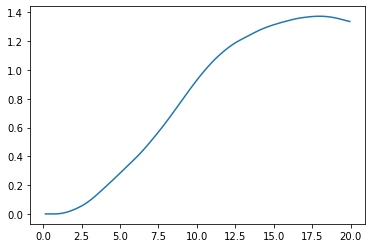

running reward: -24.90 at episode 1560


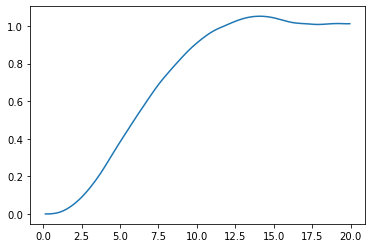

running reward: -25.09 at episode 1570


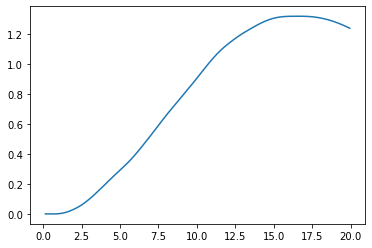

running reward: -26.27 at episode 1580


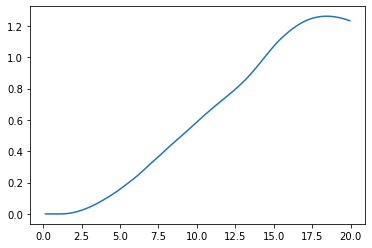

running reward: -27.56 at episode 1590


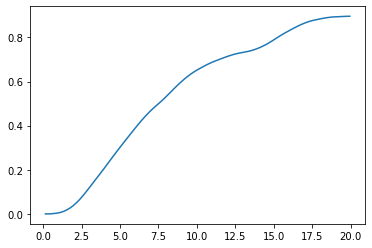

running reward: -31.13 at episode 1600


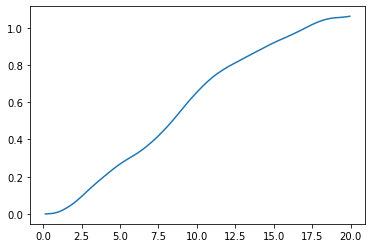

running reward: -33.98 at episode 1610


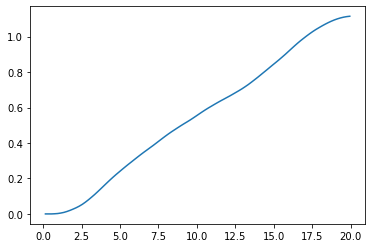

running reward: -36.59 at episode 1620


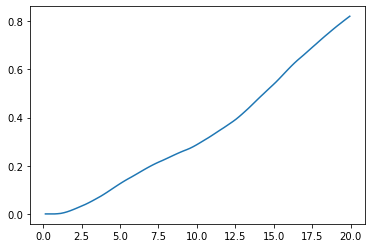

running reward: -42.69 at episode 1630


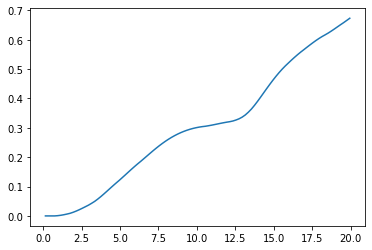

running reward: -44.62 at episode 1640


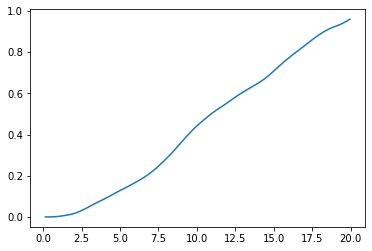

running reward: -42.35 at episode 1650


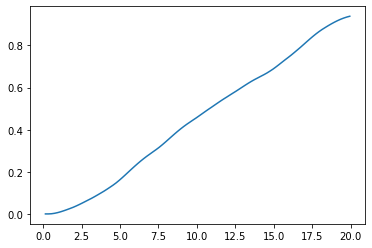

running reward: -41.71 at episode 1660


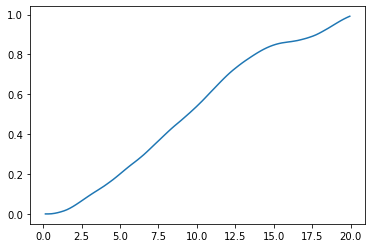

running reward: -41.53 at episode 1670


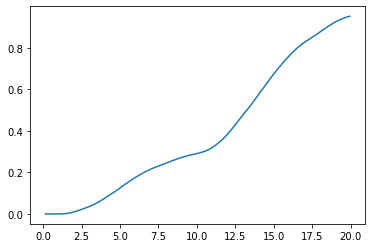

running reward: -41.49 at episode 1680


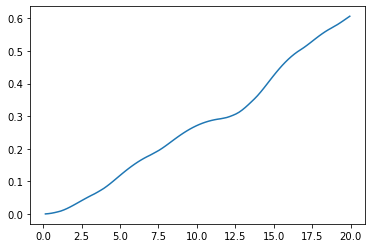

running reward: -43.42 at episode 1690


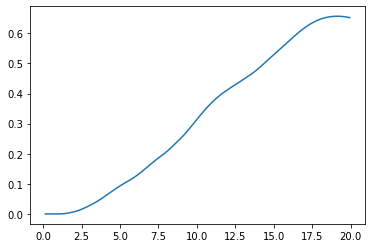

In [ ]:
#while True:  # Run until solved
while True:
    eng.workspace['actuator']=1.0 #kezdeti init és paraméter átadás a workspacenek    
    #eng.set_param(model, 'SimulationCommand', 'start', nargout=0)#Simulink modell elindítása
    state = np.array([1.,1,1,1,1,1])
    x=[]
    y=[]
    timesteps=0
    episode_reward = 0
    with tf.GradientTape() as tape:
        while (eng.get_param(model,'SimulationStatus')!=('stopped' or 'terminating')) and (max_steps_per_episode>timesteps) or timesteps==0:# one episode
           
            
            #state beolvasása - 6 múltbeli hiba
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)               
            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model1(state)
            critic_value_history.append(critic_value[0, 0])
            
            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            # Apply the sampled action in our environment
            hiba,kimenet,ido=simulation_step(float(action),timesteps)                             
            state, reward, done = step_value(hiba,state)
            
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

            #print(state)
            #print(float(action_value))
            #print(float(critic_value))

            #print(kimenet)
            #print(ido)
            x.append(ido)
            y.append(kimenet)
            
            timesteps=timesteps+1
            #print(timesteps)
        #adott episode végett ér
        eng.set_param(model,'SimulationCommand','stop',nargout=0)#fontos leállítani
        
        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model1.trainable_variables)
        optimizer.apply_gradients(zip(grads, model1.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
        plt.plot(x,y)
        plt.show()
    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


In [110]:
type(action)

int

In [111]:
float(action)

0.0

In [ ]:
plt.plot(x,y)